In [76]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import math
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from sklearn.cluster import AffinityPropagation
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns; sns.set(color_codes=True)
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import shapiro

In [2]:
#define starts and ends of genes
def bounds_of_gene(gff):
    starts=[]
    ends=[]
    gene_names=[]
    for line in gff:
        line=line.rstrip()
        values=line.split("\t")
        if(values[0][0]!="#"):
            if(values[2]=="gene"):
                gene_name, start, end=values[8], int(values[3]), int(values[4])
                gene_names.append(gene_name)
                starts.append(start)
                ends.append(end)
    return starts, ends, gene_names

In [3]:
#calculating "coordinates" of genes
def coordinates(fna, file, starts, ends):
    Coord=np.zeros([len(starts), 16])
    nucleotides=[]
    num_pairs=[]
    for i in range(len(starts)):
        num_pairs.append(ends[i]-starts[i])
    lines = fna.readlines()
    with open(file, "w") as fna_edited:
        for line in lines:
            if line.strip("\n")[0] != ">":
                fna_edited.write(line)
    with open (file, "r") as genome:
        for line in genome:
            for ch in line.strip("\n"):
                nucleotides.append(ch)
    for i in range(len(starts)):
        for j in range(starts[i]-1,ends[i]-1):
            if(nucleotides[j]=='A' and nucleotides[j+1]=='A'):
                Coord[i][0]+=1
            if(nucleotides[j]=='A' and nucleotides[j+1]=='C'):
                Coord[i][1]+=1
            if(nucleotides[j]=='A' and nucleotides[j+1]=='G'):
                Coord[i][2]+=1
            if(nucleotides[j]=='A' and nucleotides[j+1]=='T'):
                Coord[i][3]+=1
            if(nucleotides[j]=='C' and nucleotides[j+1]=='A'):
                Coord[i][4]+=1
            if(nucleotides[j]=='C' and nucleotides[j+1]=='C'):
                Coord[i][5]+=1
            if(nucleotides[j]=='C' and nucleotides[j+1]=='G'):
                Coord[i][6]+=1
            if(nucleotides[j]=='C' and nucleotides[j+1]=='T'):
                Coord[i][7]+=1
            if(nucleotides[j]=='G' and nucleotides[j+1]=='A'):
                Coord[i][8]+=1
            if(nucleotides[j]=='G' and nucleotides[j+1]=='C'):
                Coord[i][9]+=1
            if(nucleotides[j]=='G' and nucleotides[j+1]=='G'):
                Coord[i][10]+=1
            if(nucleotides[j]=='G' and nucleotides[j+1]=='T'):
                Coord[i][11]+=1
            if(nucleotides[j]=='T' and nucleotides[j+1]=='A'):
                Coord[i][12]+=1
            if(nucleotides[j]=='T' and nucleotides[j+1]=='C'):
                Coord[i][13]+=1
            if(nucleotides[j]=='T' and nucleotides[j+1]=='G'):
                Coord[i][14]+=1
            if(nucleotides[j]=='T' and nucleotides[j+1]=='T'):
                Coord[i][15]+=1
    for i in range(len(num_pairs)):
        for j in range(Coord.shape[1]):
            Coord[i][j]=Coord[i][j]/num_pairs[i]
    return Coord

In [4]:
#function for the double check
def DbSCAN(X, eps, m):
    def dbscan_get_neighbours(point_id, distances, eps):
        return np.where((distances[point_id][:] > 0) & (distances[point_id][:] < eps))[0]
    
    def dbscan_get_recursive_neighbours(points, distances, checked_points, m, eps):
        new_checked_points = set(checked_points)
        for point in points:
            if point not in new_checked_points:
                new_checked_points.add(point)
                point_neighbours = dbscan_get_neighbours(point, distances, eps)
                if point_neighbours.shape[0] >= m:
                    new_checked_points = new_checked_points.union(
                        dbscan_get_recursive_neighbours(point_neighbours, distances,
                                                        new_checked_points, m, eps))
        return new_checked_points

    import random
    distances = distance.cdist(X, X, metric='euclidean')
    n = X.shape[0]
    noise_points = set([])
    unknown_points = set([])
    unchecked_points = set(np.arange(n))
    point2class = np.zeros(n)
    cur_class = 1
    while len(unchecked_points) > 0:
        start_point = list(unchecked_points)[0]
        unchecked_points.remove(start_point)
        point_neighbours = dbscan_get_neighbours(start_point, distances, eps)
        if point_neighbours.shape[0] == 0:
            noise_points.add(start_point)
        elif point_neighbours.shape[0] < m:
            unknown_points.add(start_point)
        else:
            point2class[start_point] = cur_class
            
            checked_points = set(np.arange(n)) - unchecked_points
            new_checked_points = dbscan_get_recursive_neighbours(point_neighbours, distances,
                                                                 checked_points, m, eps)
            for point in new_checked_points:
                if point not in checked_points:
                    unchecked_points.remove(point)
                    point2class[point] = cur_class
            checked_points = new_checked_points
            cur_class += 1
    for point in unknown_points:
        point_neighbours = dbscan_get_neighbours(point, distances, eps)
        classes = point2class[point_neighbours]
        classes = classes[classes > 0]
        if classes.shape[0] > 0:
            point2class[point] = int(Counter(classes).most_common()[0][0])
    return point2class

Calculating coordinates for the genome of one bacteria

In [5]:
gff=open("Streptococcus_pneumoniae_genes.txt", "r")
starts, ends, gene_names=bounds_of_gene(gff)
fna=open("Streptococcus_pneumoniae.txt", "r")
Coord=coordinates(fna, "new_file.txt", starts, ends)

Parameters for DBSCAN

In [6]:
MinPts=math.log1p(Coord.shape[0])

In [7]:
MinPts

7.543802867501509

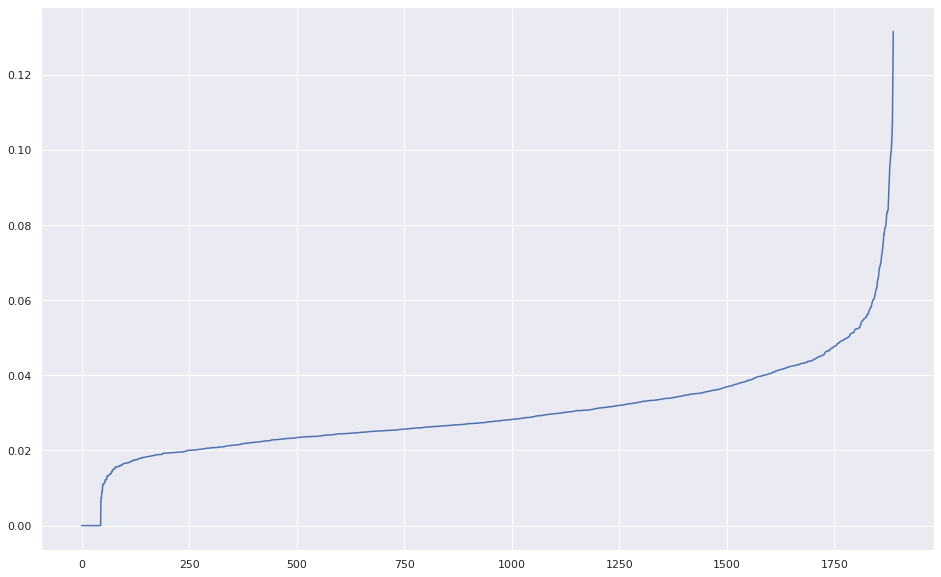

In [8]:
#eps 
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(Coord)
distances, indices = nbrs.kneighbors(Coord)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(16, 10))
plt.plot(distances)

**DBSCAN results**

Function from sklearn

In [13]:
clusters=DBSCAN(eps=0.5, min_samples=8).fit(Coord)

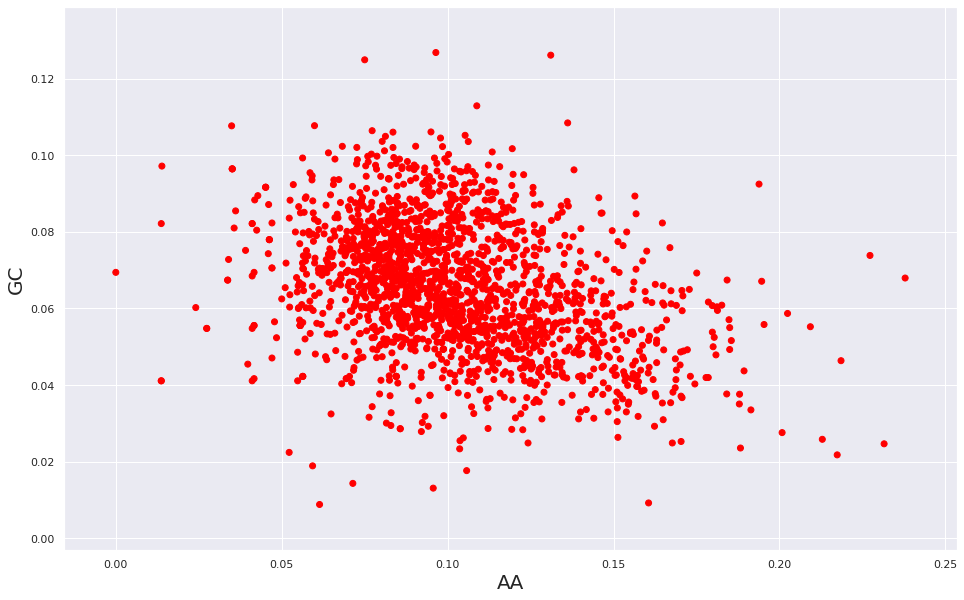

In [14]:
#AA_GC
plt.figure(figsize=(16, 10))
plt.ylabel('GC', fontsize=20)
plt.xlabel('AA', fontsize=20)
plt.scatter(Coord[:, 0], Coord[:, 13], c=clusters.labels_, cmap='rainbow_r')

Other DBSCAN-Function for the double check

In [11]:
clusters=DbSCAN(Coord, 0.5, 8)

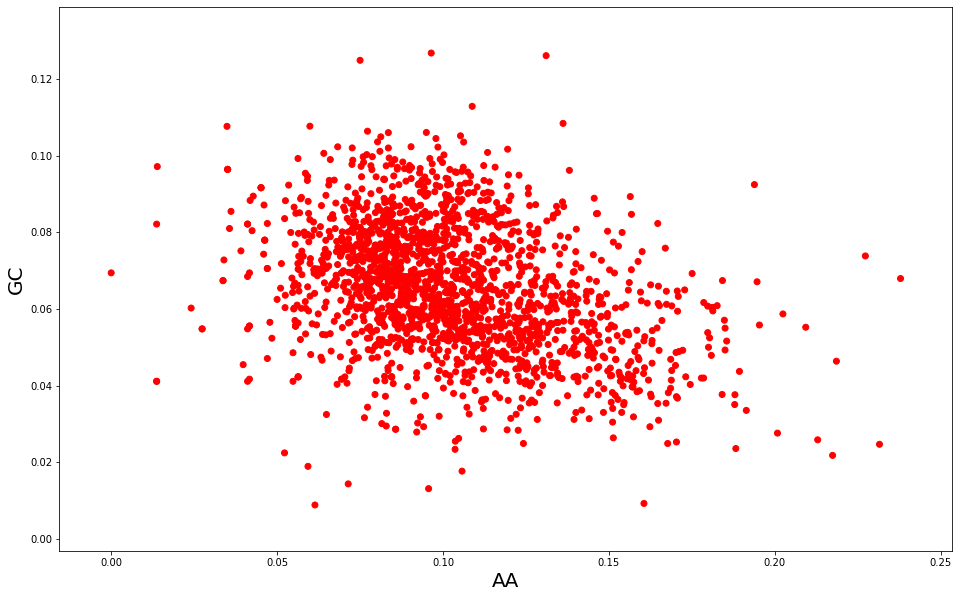

In [12]:
#AA_GC
plt.figure(figsize=(16, 10))
plt.ylabel('GC', fontsize=20)
plt.xlabel('AA', fontsize=20)
plt.scatter(Coord[:, 0], Coord[:, 13], c=clusters, cmap='rainbow_r')

**Affinity Propagation**

In [13]:
af = AffinityPropagation().fit(Coord)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_=len(cluster_centers_indices )

In [14]:
n_clusters_

116

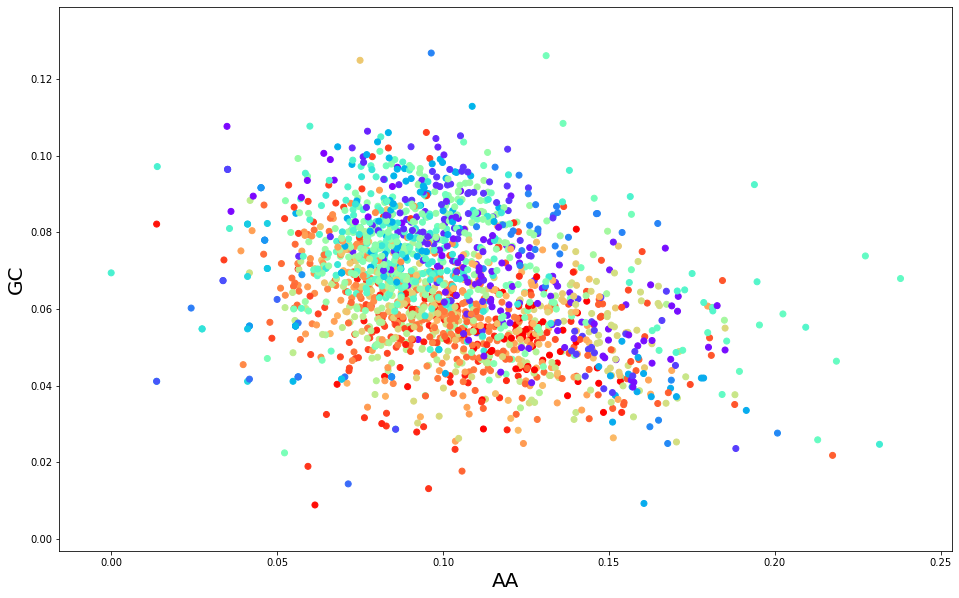

In [15]:
#AA_GC
plt.figure(figsize=(16, 10))
plt.ylabel('GC', fontsize=20)
plt.xlabel('AA', fontsize=20)
plt.scatter(Coord[:, 0], Coord[:, 13], c=labels, cmap='rainbow_r')

### Hierarchical Clustering with Ward linkage

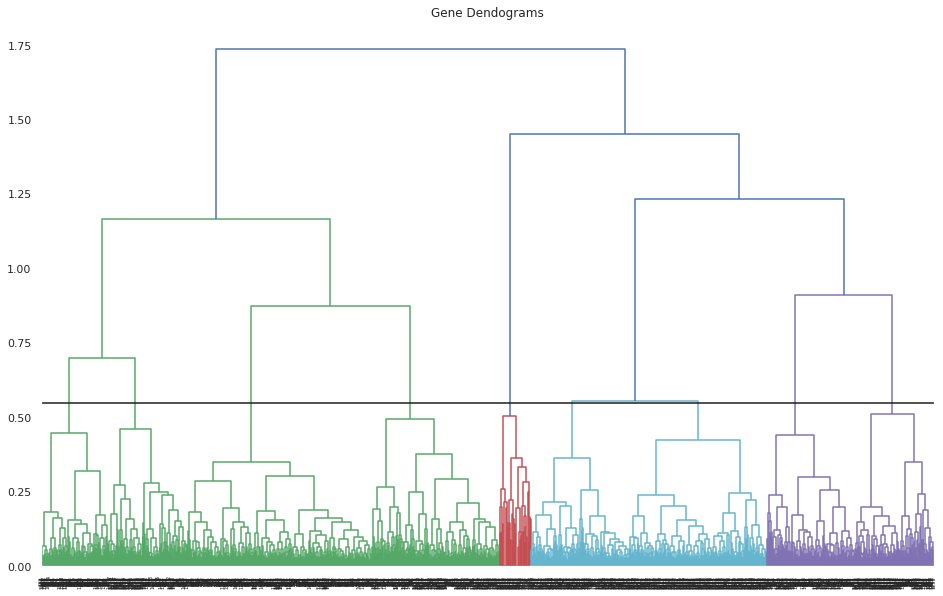

In [136]:
plt.figure(figsize=(16, 10))
plt.title("Gene Dendograms")
dend = dendrogram(linkage(Coord, method='ward'))
plt.axhline(y=0.55, c='k')

In [133]:
Z=linkage(Coord, method='ward')
max_d = 0.55
clusters = fcluster(Z, max_d, criterion='distance')

In [134]:
np.unique(clusters)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

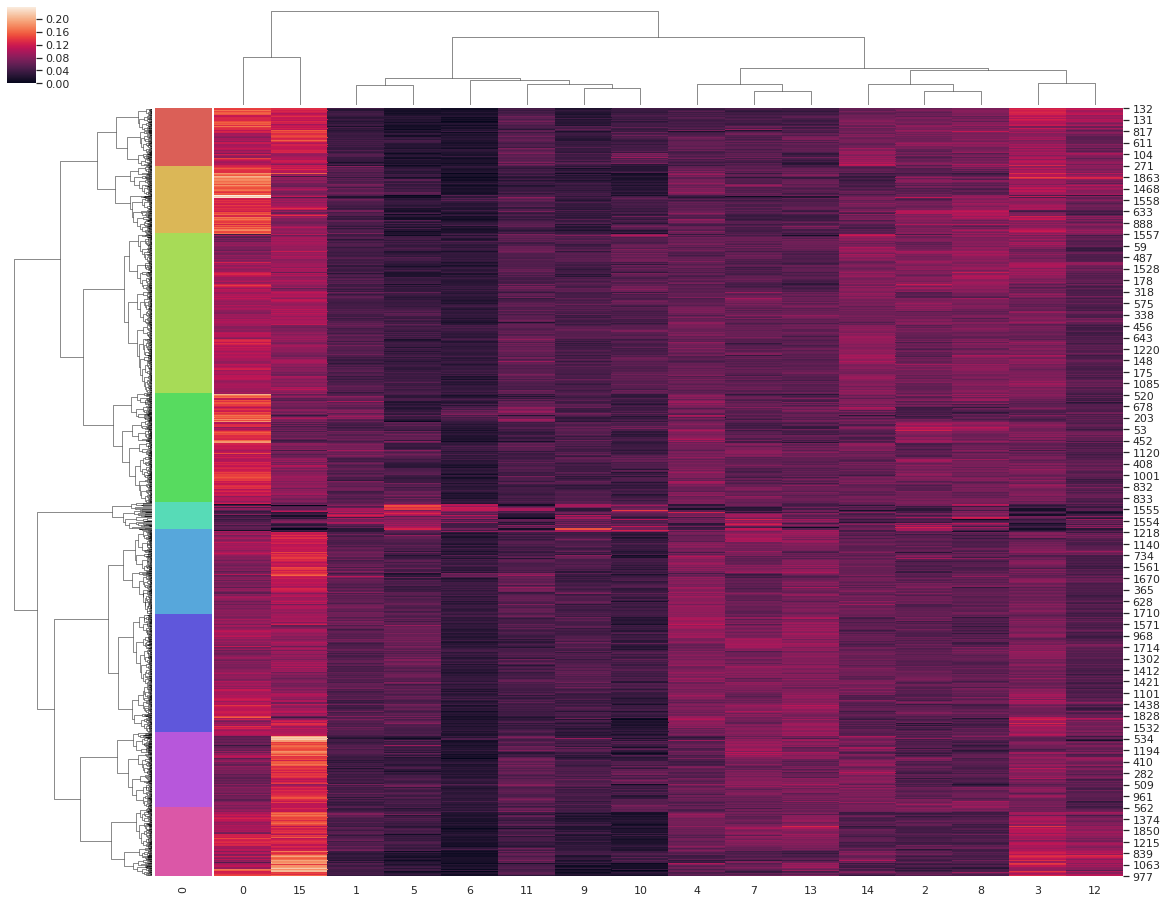

In [155]:
lut = dict(zip(set(clusters), sns.hls_palette(len(set(clusters)))))
row_colors = pd.DataFrame(clusters)[0].map(lut)
g = sns.clustermap(pd.DataFrame(Coord), figsize=(20,16), method='ward', row_colors=row_colors)

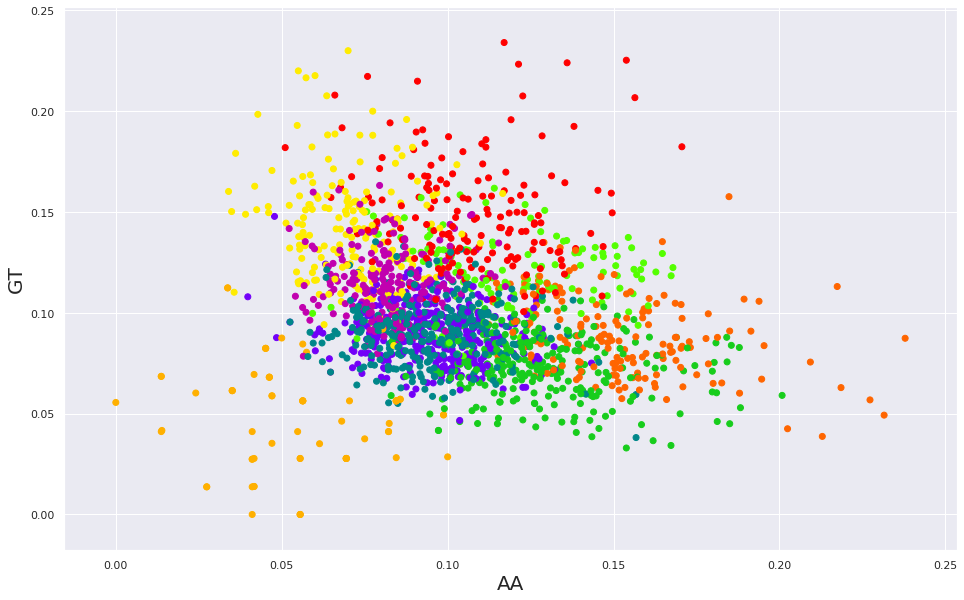

In [135]:
plt.figure(figsize=(16, 10))
plt.ylabel('GT', fontsize=20)
plt.xlabel('AA', fontsize=20)
plt.scatter(Coord[:, 0], Coord[:, 15], c=clusters, cmap='prism_r')

### Outliers

**Isolation Forest**

In [92]:
clf = IsolationForest(behaviour='new',contamination='auto',  random_state=0 ).fit(Coord)

In [93]:
outliers=clf.predict(Coord)

In [96]:
num_outliers=0
for i in outliers:
    if(i==-1):
        num_outliers+=1

Text(0.5, 1.0, 'Numer of outliers:162')

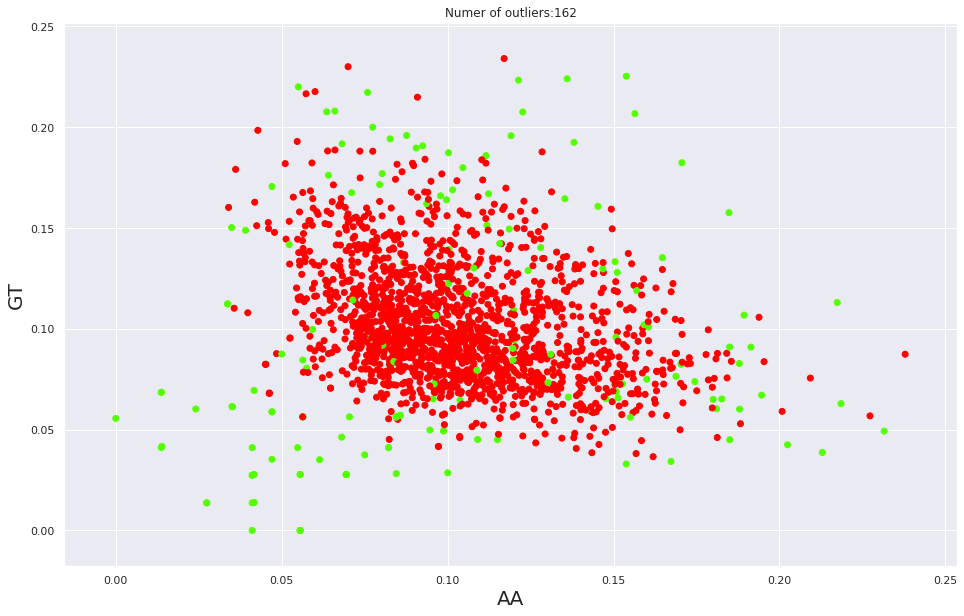

In [97]:
plt.figure(figsize=(16, 10))
plt.ylabel('GT', fontsize=20)
plt.xlabel('AA', fontsize=20)
plt.scatter(Coord[:, 0], Coord[:, 15], c=outliers, cmap='prism_r')
plt.title(f'Numer of outliers:{num_outliers}')

**Local Outlier Factor**

In [101]:
clf=LocalOutlierFactor(contamination='auto', n_neighbors=300)
outliers=clf.fit_predict(Coord)

In [103]:
num_outliers=0
for i in outliers:
    if(i==-1):
        num_outliers+=1

Text(0.5, 1.0, 'Numer of outliers:106')

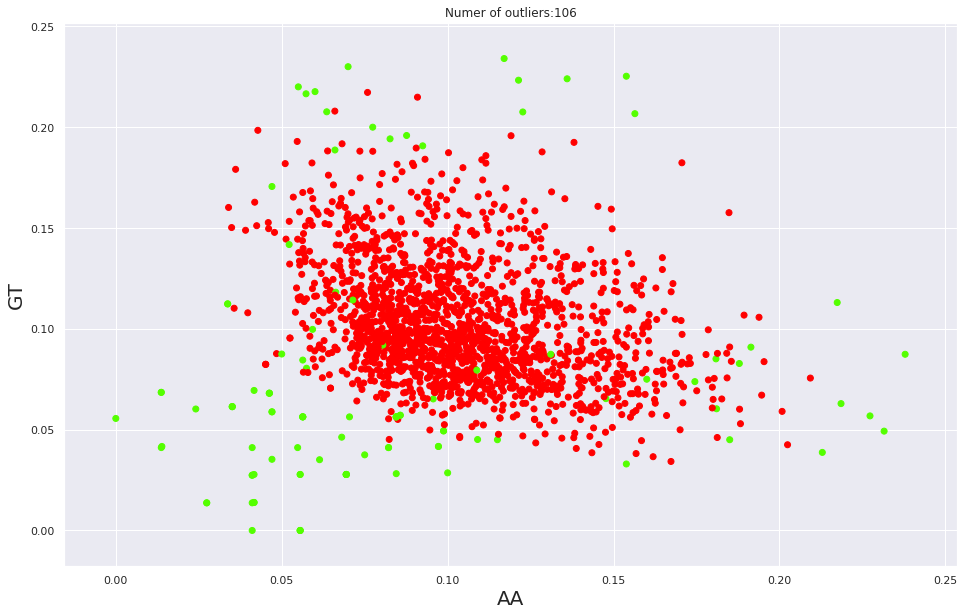

In [104]:
plt.figure(figsize=(16, 10))
plt.ylabel('GT', fontsize=20)
plt.xlabel('AA', fontsize=20)
plt.scatter(Coord[:, 0], Coord[:, 15], c=outliers, cmap='prism_r')
plt.title(f'Numer of outliers:{num_outliers}')

***Mean gene length***

In [105]:
#Percentage of outliers which length is less than mean gene length
length=0
num_short=0
for i in range(Coord.shape[0]):
    length+=ends[i]-starts[i]+1
av_length=length/len(starts)
for i in range(Coord.shape[0]):
    if outliers[i]==-1:
        if (ends[i]-starts[i]+1<av_length):
            num_short+=1
percentage=num_short/num_outliers

In [106]:
percentage

0.9622641509433962

In [107]:
#Percentage of genes which length is less than mean gene length
num_short_1=0
for i in range(Coord.shape[0]):
    if (ends[i]-starts[i]+1<av_length):
        num_short_1+=1
percentage_1=num_short_1/len(starts)

In [108]:
percentage_1

0.604343220338983

***Standard deviation***

In [109]:
#Calculating gene lengths
lengths=np.zeros(len(starts))
for i in range(len(starts)):
    lengths[i]=ends[i]-starts[i]+1

In [130]:
#mean length - standart deviation
np.mean(lengths)-np.std(lengths)

221.84151600174334

In [133]:
#number of outliers which length is less than 222
num=0
for i in range(lengths.shape[0]):
    if(lengths[i]<222 and outliers[i]==-1):
        num+=1

In [134]:
#percentage of short outliers 
num/num_outliers

0.839622641509434